# Uncertainty in Computer Vision

## Evidential Neural Network

This notebook contains an implementation of an Evidential Neural Network (ENN) for classification uncertainty estimation. The model is built upon an adapted basic convolutional neural network (LeNet).

The implementation is strongly based on the notebook provided by Murat Sensoy - https://muratsensoy.github.io/uncertainty.html

**This notebook is meant for demonstration purposes and does not include optimal training parameters**

_Author: Domantas Giržadas, 2022_

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms

# For SSL certificate error during dataset download
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [52]:
# Setting up the cuda device for performing computations on a GPU
if torch.cuda.is_available():  
    device = torch.device("cuda:0")
    print(f"Current device: {torch.cuda.get_device_name(device)}")
else:
    device = torch.device("cpu")
    print(f"Current device: CPU")

Current device: NVIDIA GeForce RTX 3080


In [3]:
# Initialising the dataset loaders for training and test sets

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='data/', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=5,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='data/', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=5,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')def imshow(img):
    """
    Function for visualising the images from the CIFAR-10 dataset
    """
    img = img / 2 + 0.5     # (unnormalizing)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Files already downloaded and verified
Files already downloaded and verified


In [4]:
def imshow(img):
    """
    Function for visualising the images from the CIFAR-10 dataset
    """
    img = img / 2 + 0.5     # (unnormalizing)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

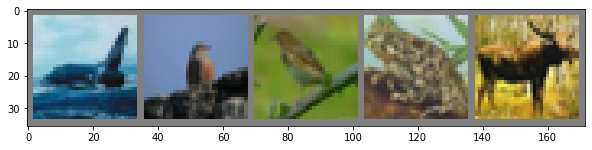

        plane          bird          bird          frog          deer


In [5]:
# Getting a batch of images from the dataset and visualising them
dataiter = iter(trainloader)
images, labels = dataiter.next()

plt.figure(figsize=(10,5))
imshow(torchvision.utils.make_grid(images))
# Print image labels
print(' '.join('%13s' % classes[labels[j]] for j in range(len(images))))

# Evidential Neural Network

In [14]:
import torch.nn as nn
import torch.nn.functional as F
class LeNet_ENN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))+1
        return x

net = LeNet_ENN().to(device)

In [15]:
# Defining the custom loss for ENN training

K = 10 # Number of classes

def one_hot_embedding(labels, num_classes=10):
    # Convert to One Hot Encoding
    y = torch.eye(num_classes)
    return y[labels]

def KL(alpha):
    alpha = alpha.to(device)
    beta= torch.from_numpy(np.ones((1,K))).to(device)
    S_alpha = alpha.sum(axis = 1, keepdims=True)
    S_beta = beta.sum(axis = 1, keepdims=True)
    lnB = torch.lgamma(S_alpha) - torch.lgamma(alpha).sum(axis = 1, keepdims=True)
    lnB_uni = torch.lgamma(beta).sum(axis = 1, keepdims=True) - torch.lgamma(S_beta)
    
    dg0 = torch.digamma(S_alpha)
    dg1 = torch.digamma(alpha)
    
    kl = ((alpha - beta)*(dg1-dg0)).sum(axis = 1, keepdims=True) + lnB + lnB_uni
    return kl

def dirichlet_loss(t, alpha, global_step, annealing_step, func = torch.digamma):
    S = alpha.sum(axis = 1, keepdims=True)
    E = alpha - 1

    A = (t * (func(S) - func(alpha))).sum(axis = 1, keepdims=True)

    annealing_coef = np.min([1.0, global_step/annealing_step])

    alp = E*(1-t) + 1 
    B =  annealing_coef*KL(alp)
    
    loss = (A+B).mean()
    
    return loss

In [16]:
# Initialising the training parameters
import torch.optim as optim

criterion = dirichlet_loss

max_iteration = len(trainloader) * 20
lambda_poly = lambda iteration: pow((1.0 - iteration / max_iteration), 0.9)

optimizer = optim.Adam(net.parameters())
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_poly)

In [17]:
# Model training
for epoch in range(20):  # loop over the dataset 20 times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(one_hot_embedding(labels).float(), outputs, i, 10*len(trainloader))
        loss.backward()
        optimizer.step()
        scheduler.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

D:\Anaconda\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[1,  2000] loss: 2.559
[1,  4000] loss: 2.428
[1,  6000] loss: 2.381
[1,  8000] loss: 2.379
[1, 10000] loss: 2.353
[2,  2000] loss: 2.200
[2,  4000] loss: 2.248
[2,  6000] loss: 2.243
[2,  8000] loss: 2.246
[2, 10000] loss: 2.248
[3,  2000] loss: 2.109
[3,  4000] loss: 2.151
[3,  6000] loss: 2.175
[3,  8000] loss: 2.196
[3, 10000] loss: 2.204
[4,  2000] loss: 2.057
[4,  4000] loss: 2.078
[4,  6000] loss: 2.129
[4,  8000] loss: 2.152
[4, 10000] loss: 2.161
[5,  2000] loss: 2.001
[5,  4000] loss: 2.067
[5,  6000] loss: 2.062
[5,  8000] loss: 2.131
[5, 10000] loss: 2.127
[6,  2000] loss: 1.971
[6,  4000] loss: 2.012
[6,  6000] loss: 2.047
[6,  8000] loss: 2.084
[6, 10000] loss: 2.101
[7,  2000] loss: 1.960
[7,  4000] loss: 1.963
[7,  6000] loss: 2.010
[7,  8000] loss: 2.049
[7, 10000] loss: 2.078
[8,  2000] loss: 1.898
[8,  4000] loss: 1.958
[8,  6000] loss: 2.004
[8,  8000] loss: 2.016
[8, 10000] loss: 2.059
[9,  2000] loss: 1.895
[9,  4000] loss: 1.947
[9,  6000] loss: 1.968
[9,  8000] 

In [53]:
# Optionally, save the model to a .pt file
torch.save(net, "model-ENN.pt")

## Evaluation

In [ ]:
net = torch.load("model-ENN.pt")

In [51]:
# Evaluate training and validation accuracy

train_hits = []
test_hits = []

for i, data in enumerate(trainloader):
    print(f"Training set... \t{i+1} / {len(trainloader)}", end = '\r')
    inputs, labels = data
    inputs = inputs.to(device)
    pred_enn_alphas = net(inputs).cpu().detach().numpy()
    pred_enn = pred_enn_alphas/pred_enn_alphas.sum(axis=1)[:,None]

    train_hits.extend(np.array(np.argmax(pred_enn, axis = 1)) == np.array(labels))
    
print("                               ",end='\r')

for i, data in enumerate(testloader):
    print(f"Validation set... \t{i+1} / {len(testloader)}\t", end = '\r')
    inputs, labels = data
    inputs = inputs.to(device)
    pred_enn_alphas = net(inputs).cpu().detach().numpy()
    pred_enn = pred_enn_alphas/pred_enn_alphas.sum(axis=1)[:,None]

    test_hits.extend(np.array(np.argmax(pred_enn, axis = 1)) == np.array(labels))

    
print("                               ",end='\r')
print(f"Training accuracy: {np.mean(train_hits)*100:.3f}%")
print(f"Validation accuracy: {np.mean(test_hits)*100:.3f}%")

Training accuracy: 57.512%     
Validation accuracy: 45.970%


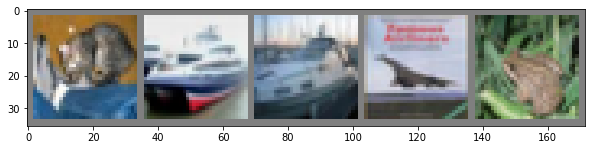

          cat          ship          ship         plane          frog


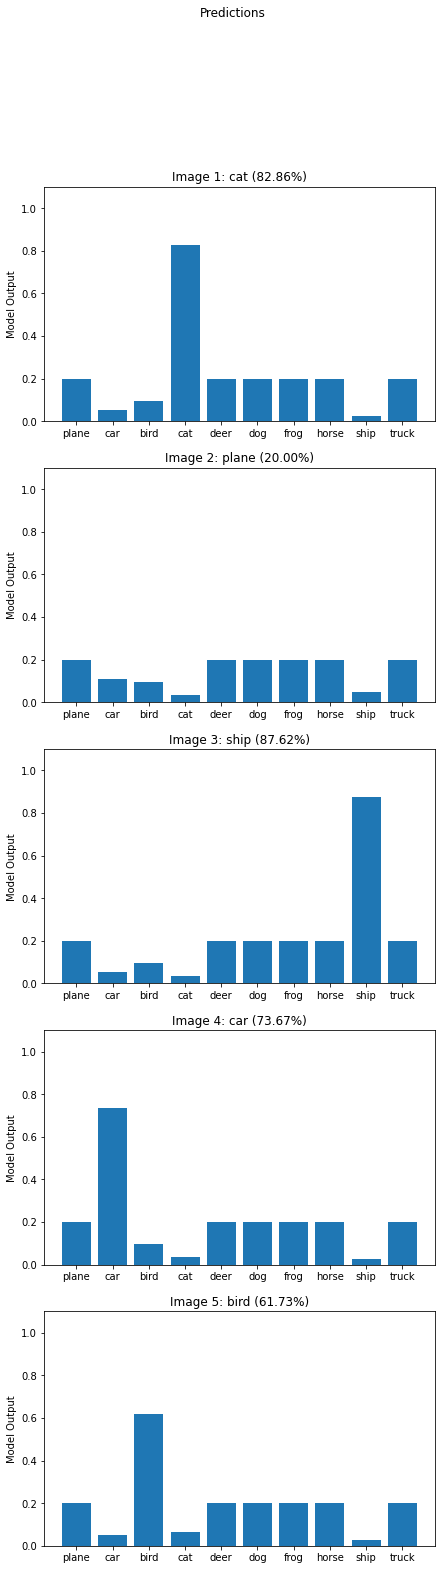

In [50]:
# Predict a batch of validation images and visualise the model output
dataiter = iter(testloader)

images, labels = dataiter.next()
plt.figure(figsize=(10,5))
imshow(torchvision.utils.make_grid(images))
print(' '.join('%13s' % classes[labels[j]] for j in range(len(images))))

images = images.to(device)
net_outputs = net(images).cpu().detach().numpy()
net_outputs /= net_outputs.sum(axis=0) # To get confidence predictions, normalising the alpha estimations

fig, axs = plt.subplots(len(images), 1, figsize=(7,25))
plt.setp(axs, xticks=np.arange(10), xticklabels=classes, ylim=(0,1.1), ylabel="Model Output")
fig.suptitle('Predictions')

for i in range(len(images)):
    axs[i].bar(np.arange(10), np.array(net_outputs[i]))
    axs[i].set_title(f"Image {i+1}: {classes[np.argmax(net_outputs[i])]} ({net_outputs[i].max()*100:.2f}%)")
plt.show()